In [1]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import h5py as h5


import re
import astropy.units as u
from scipy.spatial import cKDTree
from numba import njit, prange
from scipy.interpolate import interp1d
import matplotlib as mpl
from scipy.optimize import root_scalar
import glob

from rbf.interpolate import KNearestRBFInterpolant
from sklearn.cluster import KMeans
from joblib import Parallel, delayed

time_conv = 977.79222167

In [2]:
def read_bar_prop(name):
    prefix = '/n/home01/abeane/starbar/plots/'
    prefix_bar_prop = prefix + 'bar_prop/data/'
    
    fin = prefix_bar_prop + 'bar_prop_' + name + '.hdf5'
    h5in = h5.File(fin, mode='r')
    
    out = {}
    for key in h5in.keys():
        if key=='bar_prop':
            out[key] = {}
            for k2 in h5in[key].keys():
                out[key][k2] = np.array(h5in[key][k2])
        else:
            out[key] = np.array(h5in[key])
    
    h5in.close()
    
    return out

def get_nchunk_in_bar(name):
    prefix = '/n/home01/abeane/starbar/plots/'
    prefix_in_bar = prefix + 'in_bar/data/'
    
    nchunk = len(glob.glob(prefix_in_bar + 'in_bar_' + name + '/in_bar_' + name + '.*.hdf5'))
    return nchunk

def read_in_bar(name, chunk_idx):
    prefix = '/n/home01/abeane/starbar/plots/'
    prefix_in_bar = prefix + 'in_bar/data/'
    
    fin = prefix_in_bar + 'in_bar_' + name + '/in_bar_' + name + '.' + str(chunk_idx) + '.hdf5'
    h5in = h5.File(fin, mode='r')
    
    out = {}
    for key in h5in.keys():
        out[key] = np.array(h5in[key])
    
    h5in.close()
    return out

def read_all_in_bar(name):
    nchunk = get_nchunk_in_bar(name)
    
    in_bar_list = []
    for i in tqdm(range(nchunk)):
        in_bar = read_in_bar(name, i)
        in_bar_list.append(in_bar)
    
    return in_bar_list


In [3]:
bar_prop_Nbody4 = read_bar_prop('Nbody-lvl4')
bar_prop_Nbody3 = read_bar_prop('Nbody-lvl3')
bar_prop_gas4 = read_bar_prop('phantom-vacuum-Sg20-Rc3.5-lvl4')
bar_prop_gas3 = read_bar_prop('phantom-vacuum-Sg20-Rc3.5-lvl3')

In [5]:
np.where(np.isnan(bar_prop_gas3['bar_prop']['Rbar']))

(array([], dtype=int64),)

/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


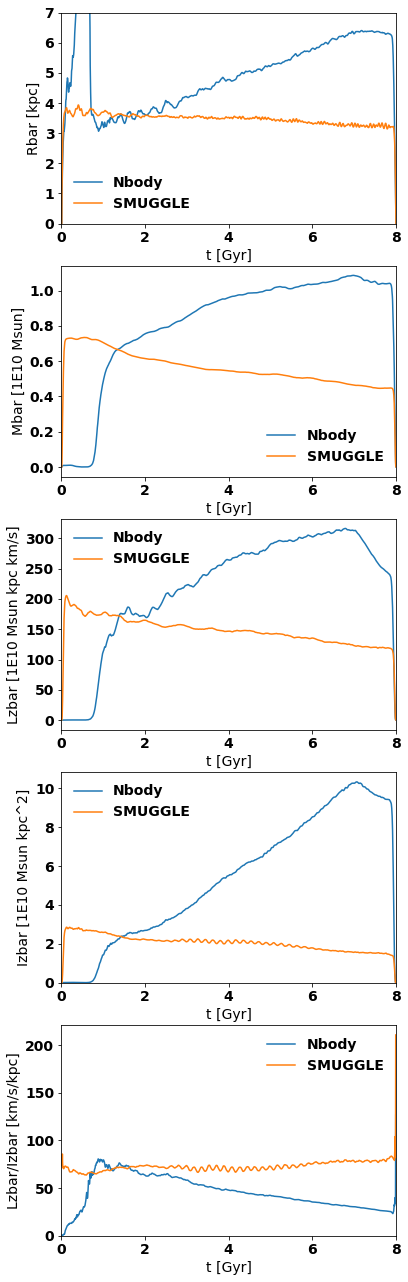

In [14]:
font = {'family' : 'normal',
        'size'   : 14}

mpl.rc('font', **font)

fig, ax = plt.subplots(5, 1, figsize=(6, 2*9*5/4))



label1 = 'Nbody'
label2 = 'SMUGGLE'

out1 = bar_prop_Nbody3
out2 = bar_prop_gas3

bar_prop = out1['bar_prop']
bar_prop2 = out2['bar_prop']


# ax[0].plot(bar_prop['tlist'], bar_prop['bar_frac'])
# ax[0].plot(bar_prop2['tlist'], bar_prop2['bar_frac'])

ax[0].plot(bar_prop['tlist'], bar_prop['Rbar'], label=label1)
ax[0].plot(bar_prop2['tlist'], bar_prop2['Rbar'], label=label2)

ax[1].plot(bar_prop['tlist'], bar_prop['Mbar'], label=label1)
ax[1].plot(bar_prop2['tlist'], bar_prop2['Mbar'], label=label2)

ax[2].plot(bar_prop['tlist'], bar_prop['Lzbar'], label=label1)
ax[2].plot(bar_prop2['tlist'], bar_prop2['Lzbar'], label=label2)

# ax[3].plot(bar_prop['tlist'], bar_prop['Lzbar']/bar_prop['Mbar'])
# ax[3].plot(bar_prop2['tlist'], bar_prop2['Lzbar']/bar_prop2['Mbar'])

ax[3].plot(bar_prop['tlist'], bar_prop['Izbar'], label=label1)
ax[3].plot(bar_prop2['tlist'], bar_prop2['Izbar'], label=label2)

l1 = ax[4].plot(bar_prop['tlist'], bar_prop['Lzbar']/bar_prop['Izbar'], label=label1)
l2 = ax[4].plot(bar_prop2['tlist'], bar_prop2['Lzbar']/bar_prop2['Izbar'], label=label2)

ps1 = np.gradient(out1['bar_angle'], out1['tlist'])
ps2 = np.gradient(out2['bar_angle'], out2['tlist'])

# ax[4].scatter(bar_prop['tlist'], ps1, c=l1[0].get_color(), s=1)
# ax[4].scatter(bar_prop2['tlist'], ps2, c=l2[0].get_color(), s=1)

ax[0].set(xlim=(0, 8))
# ax[0].set(xlim=(2, 3))

# ax[0].set(ylabel='frac trapped')
ax[0].set(ylabel='Rbar [kpc]', ylim=(0, 7))
ax[1].set(ylabel='Mbar [1E10 Msun]')
ax[2].set(ylabel='Lzbar [1E10 Msun kpc km/s]')
# ax[4].set(ylabel='Lzbar/Mbar', ylim=(0, 350))
ax[3].set(ylabel='Izbar [1E10 Msun kpc^2]', ylim=(0, None))
ax[4].set(ylabel='Lzbar/Izbar [km/s/kpc]', ylim=(0, None))

ax[0].legend(frameon=False)

for x in ax:
    x.set(xlabel='t [Gyr]', xlim=(0, 8))
    x.legend(frameon=False)


plt.show()


/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


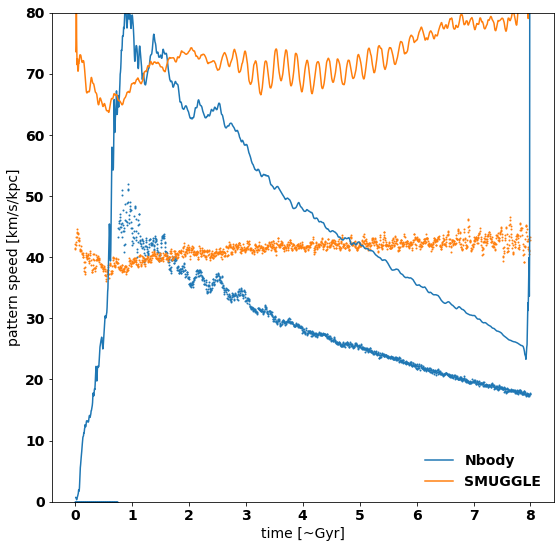

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

l1 = ax.plot(bar_prop['tlist'], bar_prop['Lzbar']/bar_prop['Izbar'], label=label1)
l2 = ax.plot(bar_prop2['tlist'], bar_prop2['Lzbar']/bar_prop2['Izbar'], label=label2)

ps1 = np.gradient(out1['bar_angle'], out1['tlist'])
ps2 = np.gradient(out2['bar_angle'], out2['tlist'])

ax.scatter(bar_prop['tlist'], ps1, c=l1[0].get_color(), s=1)
ax.scatter(bar_prop2['tlist'], ps2, c=l2[0].get_color(), s=1)

ax.set(ylim=(0, 80), xlabel='time [~Gyr]', ylabel='pattern speed [km/s/kpc]')

ax.legend(frameon=False)

plt.show()

/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


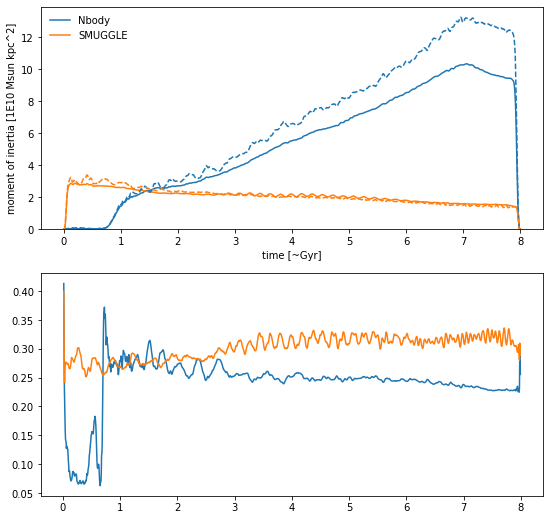

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(9, 9))

l1 = ax[0].plot(bar_prop['tlist'], bar_prop['Izbar'], label=label1)
l2 = ax[0].plot(bar_prop2['tlist'], bar_prop2['Izbar'], label=label2)

ax[0].plot(bar_prop['tlist'], 0.3 * bar_prop['Mbar'] * bar_prop['Rbar']**2, c=l1[0].get_color(), ls='dashed')
ax[0].plot(bar_prop2['tlist'], 0.3 * bar_prop2['Mbar'] * bar_prop2['Rbar']**2, c=l2[0].get_color(), ls='dashed')

ax[1].plot(bar_prop['tlist'], bar_prop['Izbar'] / (bar_prop['Mbar'] * bar_prop['Rbar']**2))
ax[1].plot(bar_prop2['tlist'], bar_prop2['Izbar'] / (bar_prop2['Mbar'] * bar_prop2['Rbar']**2))

# ps1 = np.gradient(out1['bar_angle'], out1['tlist'])
# ps2 = np.gradient(out2['bar_angle'], out2['tlist'])

# ax.scatter(bar_prop['tlist'], ps1, c=l1[0].get_color(), s=1)
# ax.scatter(bar_prop2['tlist'], ps2, c=l2[0].get_color(), s=1)

ax[0].set(ylim=(0, None), xlabel='time [~Gyr]', ylabel='moment of inertia [1E10 Msun kpc^2]')

ax[0].legend(frameon=False)

plt.show()

In [4]:
# in_bar_Nbody4 = read_all_in_bar('Nbody-lvl4')
in_bar_Nbody3 = read_all_in_bar('Nbody-lvl3')
# in_bar_gas4 = read_all_in_bar('phantom-vacuum-Sg20-Rc3.5-lvl4')
in_bar_gas3 = read_all_in_bar('phantom-vacuum-Sg20-Rc3.5-lvl3')

A Jupyter Widget

A Jupyter Widget

In [5]:
def get_frac_from_idx(in_bar_tot, idx=500):

    nsnap = len(in_bar_tot[0]['idx_list'])

    N_inbar = np.zeros(nsnap)
    N_tot = np.zeros(nsnap)
    N_fromidx = np.zeros(nsnap)
    idx = 500

    for i in tqdm(range(len(in_bar_tot))):
        in_bar_idx = in_bar_tot[i]['in_bar'][idx]
        for j in range(nsnap):
            in_bar = in_bar_tot[i]['in_bar'][j]
        
            N_inbar[j] += len(np.where(in_bar)[0])
            N_tot[j] += len(in_bar)
        
            if j <= idx:
                N_fromidx[j] += len(np.where(in_bar)[0])
            else:
                t = len(np.where(np.logical_and(in_bar, in_bar_idx))[0])
                N_fromidx[j] += t

    frac_inbar = N_inbar / N_tot
    frac_fromidx = N_fromidx / N_tot
    tlist = in_bar_tot[0]['tlist']
    
    return tlist, frac_inbar, frac_fromidx

In [6]:
# tlist_N4, finbar_N4, fidx_N4 = get_frac_from_idx(in_bar_Nbody4)
tlist_N3, finbar_N3, fidx_N3 = get_frac_from_idx(in_bar_Nbody3)
# tlist_g4, finbar_g4, fidx_g4 = get_frac_from_idx(in_bar_gas4)
tlist_g3, finbar_g3, fidx_g3 = get_frac_from_idx(in_bar_gas3)

A Jupyter Widget

A Jupyter Widget

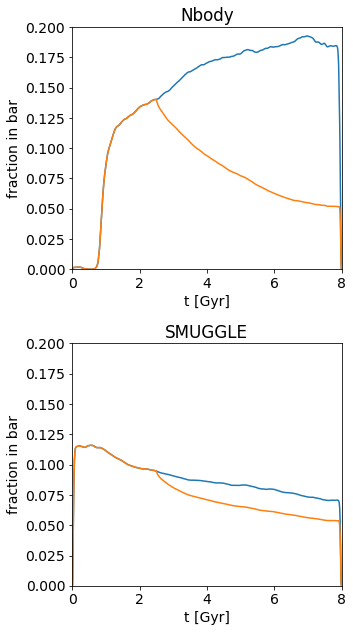

In [12]:
font = {'size'   : 14}

mpl.rc('font', **font)

fig, ax = plt.subplots(2, 1, figsize=(5, 9))

ax[0].plot(tlist_N3, finbar_N3)
ax[0].plot(tlist_N3, fidx_N3)

ax[1].plot(tlist_g3, finbar_g3)
ax[1].plot(tlist_g3, fidx_g3)

ax[0].set_title('Nbody')
ax[1].set_title('SMUGGLE')

for x in ax:
    x.set(xlim=(0, 8), ylim=(0, 0.2), xlabel='t [Gyr]', ylabel='fraction in bar')
    
fig.tight_layout()

plt.show()